In [1]:
from pe import PositionalEncoding
from model import Generator, DownsamplingLayer, FullNetwork

import torch
import torch.nn as nn
import numpy as np
from dataset import IterableSpectraDataset, collate_fn
from torch.utils.data import DataLoader

In [2]:
hdf5_dir = '../data/healpixfiles_inter'
dataset = IterableSpectraDataset(hdf5_dir, n_samples_per_spectrum=4000, n_subspectra=5, yield_full_spectrum=True)
dataloader = DataLoader(dataset, batch_size=10, collate_fn=collate_fn)

# Get the first batch
first_batch = next(iter(dataloader))

# Print shapes of wavelength and flux tensors, and the spectrum IDs
print("Wavelength shape:", first_batch['wavelength'].shape)
print("Flux shape:", first_batch['flux'].shape)
print("Spectrum IDs:", first_batch['spectrum_id'])
print("Lengths:", first_batch['length'])

Wavelength shape: torch.Size([10, 25300])
Flux shape: torch.Size([10, 25300])
Spectrum IDs: ('123_galah_370', '72_galah_376', '59_apogee_114', '59_galah_324', '172_apogee_195', '172_apogee_212', '172_galah_341', '170_apogee_165', '170_apogee_181', '170_apogee_268')
Lengths: tensor([20757, 20780,  9495, 20775,  9495,  9495, 20770,  9495,  9495,  9495])


In [39]:
def generate_wavelength_grid():
    grid = [
        (15050, 15850, 0.2),
        (15870, 16440, 0.2),
        (16475, 17100, 0.2),
        (4700, 4930, 0.05),
        (5650, 5880, 0.05),
        (6420, 6800, 0.05),
        (7500, 7920, 0.05)
    ]

    wavelength_grid = []
    for start, end, step in grid:
        wavelength_grid.extend(np.arange(start, end + step, step))
    
    return np.array(wavelength_grid)

def normalize_wavelengths(wavelengths, max_wavelength):
    return wavelengths / max_wavelength

In [42]:
# Generate wavelength grid (high resolution)
wavelength_grid = torch.tensor(generate_wavelength_grid(), dtype=torch.float16)
wavelength_grid = normalize_wavelengths(wavelength_grid, 17100)  # Normalize the wavelength grid


In [5]:
# Example configuration
latent_dim = 20  # Example latent dimension
output_dim = 20762  # Example output dimension (max length of wavelengths)
layers = [512, 512]  # Example hidden layers
activation_function = 'LeakyReLU'  # Example activation function

In [6]:
# Define Positional Encoding
pe_args = (
    1,  # Dimension of the input (wavelengths)
    10,  # pe_dim example value
    1.0,  # omega example value
    1.0,  # sigma example value
    True,  # pe_bias example value
    42  # seed example value
)

In [7]:
positional_encoding = PositionalEncoding(pe_args)

In [8]:
# Define Generator
generator_output_dim= 1
input_dim = latent_dim + pe_args[1]  # latent_dim + pe_dim
generator = Generator(input_dim, generator_output_dim, layers, activation_function)

# Define downsampling layer
downsampling_layer = DownsamplingLayer()

# Create the full network
full_network = FullNetwork(generator, downsampling_layer, positional_encoding)



In [9]:
# Example input tensors
batch_size = 10
# positional_dim = 25300  # Adjust according to your needs
latent_z = first_batch['latent_code']  # Example latent space vector


In [10]:
# Generate lower resolution real_wavelengths
real_wavelengths = first_batch['wavelength']
# real_wavelengths = real_wavelengths.unsqueeze(0).expand(batch_size, -1)  # Shape: [batch_size, 8000]



# Use positional encoding by reference
positional_encoding_ref = positional_encoding(wavelength_grid)

# Forward pass
generated_flux, high_res = full_network(latent_z, wavelength_grid, real_wavelengths)

# Print the shape of the generated flux
print(f"Generated flux shape: {generated_flux.shape}")

In [12]:
# Define the weighted MSE loss function
def weighted_mse_loss(input, target, weight):
    assert input.shape == target.shape == weight.shape, f'Shapes of input {input.shape}, target {target.shape}, and weight {weight.shape} must match'
    loss = torch.mean(weight * (input - target) ** 2) 
    return loss

In [26]:
# Optimizer
optimizer = torch.optim.Adam(full_network.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for first_batch in dataloader:
        latent_z = first_batch['latent_code']  # Example latent space vector
        real_wavelengths = normalize_wavelengths(first_batch['wavelength'], 17100)
        
        # Use positional encoding by reference
        positional_encoding_ref = positional_encoding(wavelength_grid)

        # Forward pass
        generated_flux, high_res = full_network(latent_z, wavelength_grid, real_wavelengths)

        # Example target and weight tensors
        real_flux = first_batch['flux']  # Example real flux from dataset
        weights = first_batch['weight']  # Example weights

        # Compute the weighted MSE loss
        generated_flux = generated_flux.squeeze(1)
        loss = weighted_mse_loss(generated_flux, real_flux, weights)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

print("Training completed.")

latent_z shape: torch.Size([10, 20])
wavelength_grid shape: torch.Size([34714])
real_wavelengths shape: torch.Size([10, 25300])
positional_encoding shape: torch.Size([10, 34714, 10])
latent_z_expanded shape: torch.Size([10, 34714, 20])
input_to_generator shape: torch.Size([10, 34714, 30])
generator_output shape: torch.Size([10, 34714, 1])
generator_output squeezed shape:  torch.Size([10, 34714])
high_res_flux shape: torch.Size([10, 34714])
high_res_flux shape: torch.Size([10, 34714])
high_res_wavelength shape: torch.Size([34714])
observed_wavelength shape: torch.Size([10, 25300])
Reshaped high_res_flux shape: torch.Size([10, 1, 34714, 1])
Grid shape: torch.Size([10, 1, 25300, 2])
Sampled flux shape: torch.Size([10, 1, 1, 25300])
generated_flux shape: torch.Size([10, 1, 25300])
Exception: The expanded size of the tensor (25300) must match the existing size (30935) at non-singleton dimension 0.  Target sizes: [25300].  Tensor sizes: [30935] in group 170_combined_0
Exception: The expanded

In [27]:
real_wavelengths.shape

torch.Size([6, 25300])

In [28]:
import matplotlib.pyplot as plt


def plot_flux_vs_wavelength(wavelength_grid, generated_flux, index=0):
    if isinstance(wavelength_grid, torch.Tensor):
        wavelength_grid = wavelength_grid[index].detach().cpu().numpy()
    if isinstance(generated_flux, torch.Tensor):
        generated_flux = generated_flux[index].detach().cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_grid, generated_flux, label='Generated Flux')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title(f'Generated Flux vs. Wavelength for Spectrum {index}')
    plt.legend()
    plt.grid(True)
    plt.show()

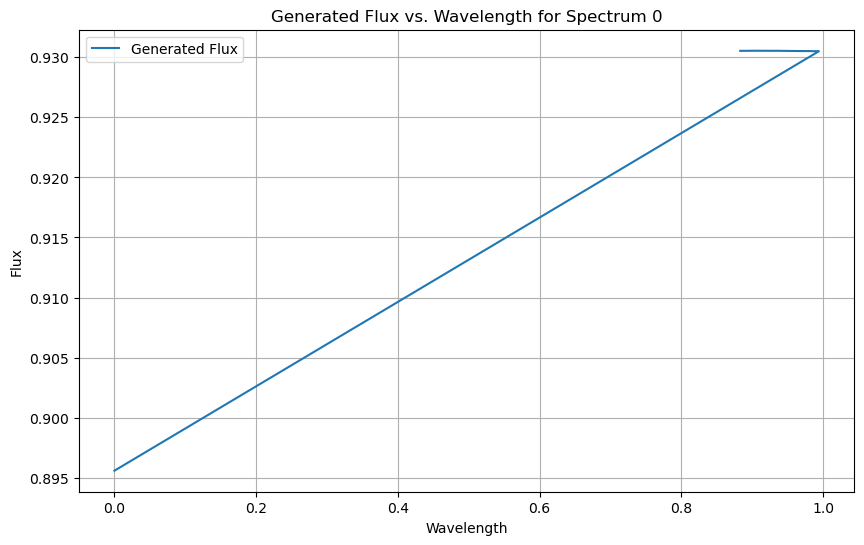

In [29]:
plot_flux_vs_wavelength(real_wavelengths, generated_flux, index=0)

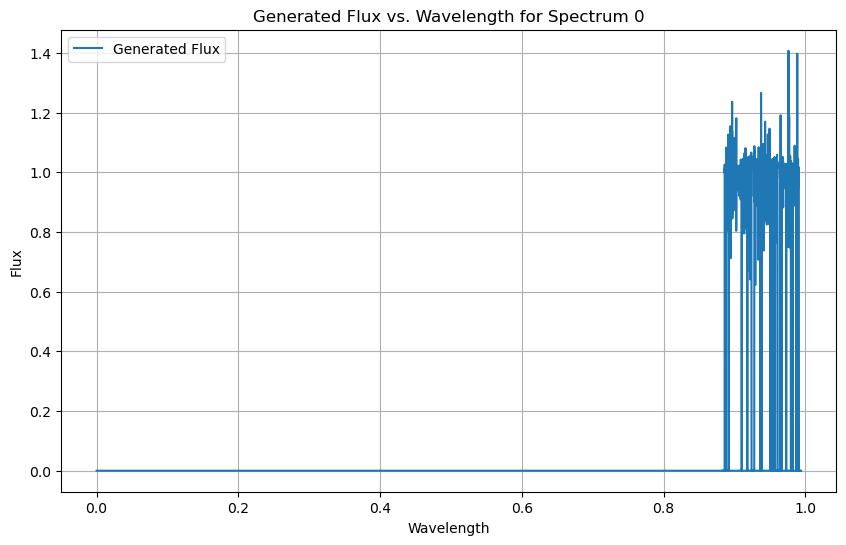

In [45]:
plot_flux_vs_wavelength(real_wavelengths, first_batch['flux'], index=0)

In [30]:
high=high_res.squeeze(-1)
high.shape

torch.Size([6, 34714])

In [31]:
wavelength_grid.shape

torch.Size([34714])

In [35]:
def plot_high(wavelength_grid, high, index=0):
    if isinstance(generated_flux, torch.Tensor):
        high = high[index].detach().cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_grid, high, label='Generated Flux')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title(f'High Resolution Spectrum vs. Wavelength for Spectrum {index}')
    plt.legend()
    plt.grid(True)
    plt.show()

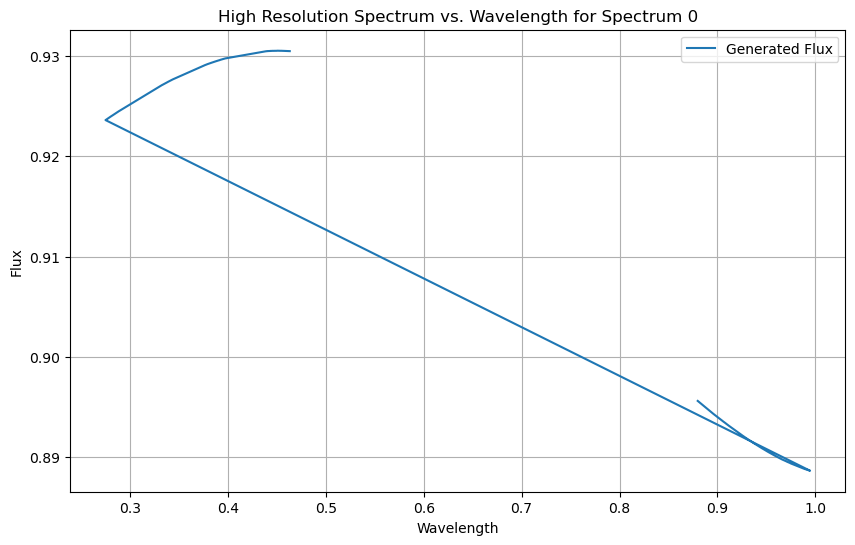

In [36]:
plot_high(wavelength_grid, high)

In [43]:
print(wavelength_grid)

tensor([0.8799, 0.8799, 0.8799,  ..., 0.4631, 0.4631, 0.4631],
       dtype=torch.float16)


In [44]:
print(normalize_wavelengths(first_batch['wavelength'],17100))

tensor([[0.8831, 0.8831, 0.8831,  ..., 0.0000, 0.0000, 0.0000],
        [0.8831, 0.8831, 0.8831,  ..., 0.0000, 0.0000, 0.0000],
        [0.8831, 0.8831, 0.8831,  ..., 0.0000, 0.0000, 0.0000],
        [0.8831, 0.8831, 0.8831,  ..., 0.0000, 0.0000, 0.0000],
        [0.8831, 0.8831, 0.8831,  ..., 0.0000, 0.0000, 0.0000],
        [0.8831, 0.8831, 0.8831,  ..., 0.0000, 0.0000, 0.0000]])
